<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/6_update_lung_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json

# Load files

In [2]:
!cp -r 'drive/MyDrive/covid/models/' .

In [3]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [4]:
!cp -r 'drive/MyDrive/covid/assets/' .

## Load other dataset

In [5]:
# covid-chestxray-dataset
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

--2023-03-22 21:18:45--  https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master [following]
--2023-03-22 21:18:45--  https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [<=>                 ] 525.03M  20.2MB/s    in 26s     

2023-03-22 21:19:11 (20.5 MB/s) - ‘master.zip’ saved [550535079]



In [6]:
!unzip master.zip

Archive:  master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
   creating: covid-chestxray-dataset-master/
   creating: covid-chestxray-dataset-master/.github/
 extracting: covid-chestxray-dataset-master/.github/FUNDING.yml  
   creating: covid-chestxray-dataset-master/.github/workflows/
  inflating: covid-chestxray-dataset-master/.github/workflows/tests.yml  
  inflating: covid-chestxray-dataset-master/.gitignore  
  inflating: covid-chestxray-dataset-master/README.md  
  inflating: covid-chestxray-dataset-master/SCHEMA.md  
   creating: covid-chestxray-dataset-master/annotations/
  inflating: covid-chestxray-dataset-master/annotations/covid-severity-scores.csv  
  inflating: covid-chestxray-dataset-master/annotations/imageannotation_ai_lung_bounding_boxes.json  
   creating: covid-chestxray-dataset-master/annotations/lungVAE-masks/
  inflating: covid-chestxray-dataset-master/annotations/lungVAE-masks/1-s2.0-S0140673620303706-fx1_lrg_mask.png  
  inflating: covid-chestxray-dataset-mas

# Prepare graph model

In [9]:
# Dependencies
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json
tf.disable_v2_behavior()

weightspath = 'models/COVIDNet-CXR-Large/' 
  
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd:0"  
'''
#conv5_block3_1_conv/convolution, post_relu/Relu,post_bn/cond/FusedBatchNorm, 
#conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, 
#conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
'''
model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'


metaname = 'model.meta'
ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224 # 480
args_input_size_medusa = 256
args_top_percent = 0.08

# save image
args_impath = "assets/ex-covid.jpeg"
args_pred_class = 'COVID-19'
args_outdir = './'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]


def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, top_percent, size):
    if filepath.split(".")[-1] == "npy":
        x_arr = np.load(filepath)
        x_arr = x_arr * 255.0 / x_arr.max()
        img = np.stack((x_arr, x_arr, x_arr), axis=-1)
    else:
        img = cv2.imread(filepath)

    processed_img = crop_top(img, percent=top_percent)
    processed_img = central_crop(processed_img)
    processed_img = cv2.resize(processed_img, (size, size))
    return processed_img, img
  
class GradCAM:
    def __init__(self, graph, classes, outLayer, targetLayer=None):
        self.graph = graph
        self.classes = classes
        self.targetLayer = targetLayer
        self.outLayer = outLayer

        if self.targetLayer is None:
            self.target = self.find_target_tensor()
        else:
            self.target = self.graph.get_tensor_by_name(self.targetLayer)

    def find_target_tensor(self):
        """
        Find the last tensor that have 4D shape if targetLayer is not specified.
        :return:
        """
        tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values() if
                   "save" not in str(t.name)]
        for tensor_name in reversed(tensor_names):
            tensor = self.graph.get_tensor_by_name(tensor_name)
            if len(tensor.shape) == 4:
                return tensor

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_grads(self):
        results = {} # grads of classes with keys being classes and values being normalized gradients
        for classIdx in self.classes:
            one_hot = tf.sparse_to_dense(classIdx, [len(self.classes)], 1.0)
            signal = tf.multiply(self.graph.get_tensor_by_name(self.outLayer),one_hot)
            loss = tf.reduce_mean(signal)

            grads = tf.gradients(loss, self.target)[0]

            norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads)))+tf.constant(1e-5))

            results[classIdx] = norm_grads

        return results


def generate_cam(conv_layer_out, grads_val, upsample_size):
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.zeros(conv_layer_out.shape[0:2], dtype=np.float32)

    # Weight averaginng
    for i, w in enumerate(weights):
        cam += w*conv_layer_out[:,:,i]

    # Apply reLU
    cam = np.maximum(cam, 0)
    cam = cam/np.max(cam)
    cam = cv2.resize(cam, upsample_size)

    # Convert to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3


sess = tf.Session()
saver = tf.train.import_meta_graph(model_path + '.meta')
saver.restore(sess, model_path2)

graph = tf.get_default_graph()

image_tensor = graph.get_tensor_by_name(args_in_tensorname)
gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

grads = gradCam.compute_grads()

x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
img_arr = np.asanyarray(x)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

x = x.astype('float32') / 255.0
output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

cam3 = generate_cam(output[0],grads_val[0],size_upsample)


# Overlay cam on image
cam3 = np.uint8(255*cam3)
cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

new_im = cam3*0.3 + origin_im*0.5

im_name = args_impath.split("/")[-1]
ext = im_name.split(".")[-1]

# Save the GradCAM
cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

print("GradCAM image is save in ", args_outdir)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


GradCAM image is save in  ./


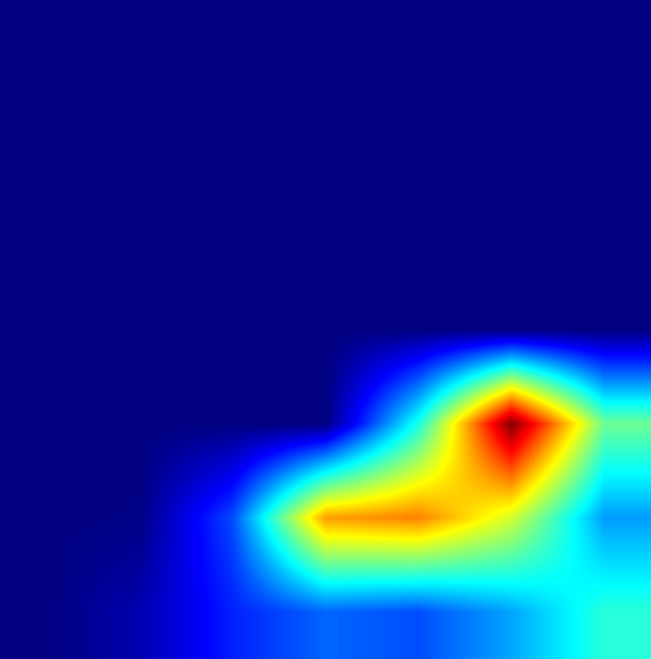

In [10]:
#  show cam image
cv2_imshow(cam3)

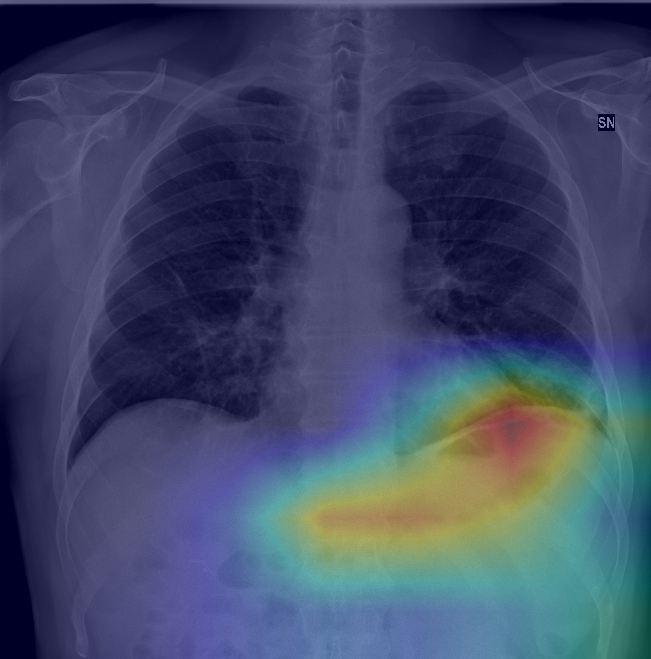

In [11]:

cv2_imshow(new_im)

# Lung Part

In [ ]:
# import numpy as np
# import cv2
# from matplotlib import pyplot as plt

# img0 = cv2.imread('./assets/ex-covid.jpeg')
# # cam3
# mask = np.zeros(img0.shape[:2],np.uint8)

# bgdModel = np.zeros((1,65),np.float64)
# fgdModel = np.zeros((1,65),np.float64)

# rect = (100, 100, 600, 550)
# # cv2.cvtColor(new_im, cv2.COLOR_RGBA2RGB)
# cv2.grabCut(img0,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

# mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# img = img0*mask2[:,:,np.newaxis]

In [ ]:
# cv2_imshow(img)

# Method

## prepare the model

In [12]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]


def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, top_percent, size):
    if filepath.split(".")[-1] == "npy":
        x_arr = np.load(filepath)
        x_arr = x_arr * 255.0 / x_arr.max()
        img = np.stack((x_arr, x_arr, x_arr), axis=-1)
    else:
        img = cv2.imread(filepath)

    processed_img = crop_top(img, percent=top_percent)
    processed_img = central_crop(processed_img)
    processed_img = cv2.resize(processed_img, (size, size))
    return processed_img, img


'''/////////////////////////main_grad/////////////////////////////'''

def main_grad(args_impath):
  # # add more photo
  # args_impath = "./covid-chestxray-dataset-master/images/000001-1.jpg"
  image_tensor = graph.get_tensor_by_name(args_in_tensorname)
  gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

  grads = gradCam.compute_grads()

  x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
  img_arr = np.asanyarray(x)
  size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

  x = x.astype('float32') / 255.0
  output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

  cam3 = generate_cam(output[0],grads_val[0],size_upsample)

  # Overlay cam on image
  cam3 = np.uint8(255*cam3)
  cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
  
  im_name = args_impath.split("/")[-1]
  ext = im_name.split(".")[-1]


  # show!!!!
  cam3_resize = cv.resize(cam3, (224, 224))
  
  # cv2.imwrite("cam-1.png", cam3_resize)
  

  new_im = cam3*0.3 + origin_im*0.5


  # Save the GradCAM
  cv2.imwrite("./output/"+os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

  # print("GradCAM image is save in ", args_outdir)

  # show images:
  # imagepath = "assets/ex-covid.jpeg"
  img_m = cv.imread(args_impath)
  img_m = cv.resize(img_m, (224, 224))

  # display(Image(imagepath))
  cv2_imshow(img_m)  # oringinal
  new_im_2 = cv.resize(new_im, (224, 224))
  cv2_imshow(new_im_2)  # grad-cam

  cv2_imshow(cam3_resize) # grad-cam-explain

  return img_m, new_im_2, cam3_resize

'''/////////////////////////main_grad/////////////////////////////'''

'''/////////////////////////bb_iou/////////////////////////////'''

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, (xB - xA + 1)) * max(0, (yB - yA + 1))
	print("interarea:", interArea)
	print("xA, yA, xB, yB:", xA, yA, xB, yB)
  
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = ((boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1))
	boxBArea = ((boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1))
	print("boxAArea:", boxAArea)
	print("boxBArea", boxBArea)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	print("boxAArea + boxBArea - interArea: ", boxAArea + boxBArea - interArea)
	print("iou: ", iou)
	# return the intersection over union value
	return iou

'''/////////////////////////bb_iou/////////////////////////////'''






class GradCAM:
    def __init__(self, graph, classes, outLayer, targetLayer=None):
        self.graph = graph
        self.classes = classes
        self.targetLayer = targetLayer
        self.outLayer = outLayer

        if self.targetLayer is None:
            self.target = self.find_target_tensor()
        else:
            self.target = self.graph.get_tensor_by_name(self.targetLayer)

    def find_target_tensor(self):
        """
        Find the last tensor that have 4D shape if targetLayer is not specified.
        :return:
        """
        tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values() if
                   "save" not in str(t.name)]
        for tensor_name in reversed(tensor_names):
            tensor = self.graph.get_tensor_by_name(tensor_name)
            if len(tensor.shape) == 4:
                return tensor

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_grads(self):
        results = {} # grads of classes with keys being classes and values being normalized gradients
        for classIdx in self.classes:
            one_hot = tf.sparse_to_dense(classIdx, [len(self.classes)], 1.0)
            signal = tf.multiply(self.graph.get_tensor_by_name(self.outLayer),one_hot)
            loss = tf.reduce_mean(signal)

            grads = tf.gradients(loss, self.target)[0]

            norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads)))+tf.constant(1e-5))

            results[classIdx] = norm_grads

        return results


def generate_cam(conv_layer_out, grads_val, upsample_size):
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.zeros(conv_layer_out.shape[0:2], dtype=np.float32)

    # Weight averaginng
    for i, w in enumerate(weights):
        cam += w*conv_layer_out[:,:,i]

    # Apply reLU
    cam = np.maximum(cam, 0)
    cam = cam/np.max(cam)
    cam = cv2.resize(cam, upsample_size)

    # Convert to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3





## Prepare 10 images

In [32]:
img_num_set = [29, 51, 73, 75, 100, 125, 179, 202, 251, 257]
'''
 img_num_set = [29, 51, 73, 75, 100, 125, 178, 199, 244, 257,
                288, 297, 325, 361, 369, 478, 498, 509, 514, 642,
              #  659, 720, 757, 763, 823, 836, 877, 890, 913, 942]
'''
# 53: radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.nii.gz unknown
# 243: radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii.gz unknown

'\n img_num_set = [29, 51, 73, 75, 100, 125, 178, 199, 244, 257,\n                288, 297, 325, 361, 369, 478, 498, 509, 514, 642,\n              #  659, 720, 757, 763, 823, 836, 877, 890, 913, 942]\n'

In [26]:
# import metedata

metadata_covid_chest = './covid-chestxray-dataset-master/metadata.csv'
pd_reader = pd.read_csv(metadata_covid_chest)
print(pd_reader)

    patientid  offset sex   age                   finding RT_PCR_positive  \
0           2     0.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
1           2     3.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
2           2     5.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
3           2     6.0   M  65.0  Pneumonia/Viral/COVID-19               Y   
4           4     0.0   F  52.0  Pneumonia/Viral/COVID-19               Y   
..        ...     ...  ..   ...                       ...             ...   
945       479     0.0   F  40.0                 Pneumonia             NaN   
946       479    70.0   F  40.0                 Pneumonia             NaN   
947       480     NaN   M  26.0                 Pneumonia             NaN   
948       481     NaN   M  50.0                 Pneumonia             NaN   
949       481     NaN   M  50.0                 Pneumonia             NaN   

    survival intubated intubation_present went_icu  ...              date  

In [27]:
image_name_all =pd_reader['filename']
PCR_result_all = pd_reader['RT_PCR_positive']

In [28]:
pd_reader.index.rename('index', inplace=True)
# lines = pd_reader2['index']
pd_reader

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
index,,,,,,,,,,,,,,,,,,,,,
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,479,0.0,F,40.0,Pneumonia,NaN,NaN,NaN,NaN,NaN,...,NaN,United Kingdom,images,072ecaf8c60a81980abb57150a8016_jumbo-9.jpeg,NaN,https://radiopaedia.org/cases/multifocal-round...,CC BY-NC-SA,Asthmatic. Shortness of breath and wheeze. Rou...,"Case courtesy of Dr Ian Bickle, Radiopaedia.or...",NaN
946,479,70.0,F,40.0,Pneumonia,NaN,NaN,NaN,NaN,NaN,...,NaN,United Kingdom,images,ff33c406392b968d483174c97eb857_jumbo-9.jpeg,NaN,https://radiopaedia.org/cases/multifocal-round...,CC BY-NC-SA,Asthmatic. Shortness of breath and wheeze. The...,"Case courtesy of Dr Ian Bickle, Radiopaedia.or...",NaN
947,480,NaN,M,26.0,Pneumonia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,images,000001-266.jpg,NaN,https://www.eurorad.org/case/947,CC BY-NC-SA 4.0,fire-eater accidentally ingested a paraffin mi...,NaN,NaN


In [18]:
# # example 10
# for i in range(10):
#   num = img_num_set[i]
#   print("Num#:", num)
#   print(image_name_all[num])
#   temp_name = pd_reader['filename'][num]
#   print("Current img:", temp_name)
#   main_grad('./covid-chestxray-dataset-master/images/' + temp_name)
#   # main_grad('./covid-chestxray-dataset-master/images/' + image_name_all[num])
#   print(i, PCR_result_all[num])

## Prepare graph model

In [ ]:
tf.disable_v2_behavior()
weightspath = 'models/COVIDNet-CXR-Large/' 
  
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd:0"  

model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'

metaname = 'model.meta'
ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224 # 480
args_input_size_medusa = 256
args_top_percent = 0.08

# save image
args_impath = "assets/ex-covid.jpeg"
args_pred_class = 'COVID-19'
args_outdir = './'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}



# if __name__ == '__main__':
sess = tf.Session()

saver = tf.train.import_meta_graph(model_path + '.meta')

saver.restore(sess, model_path2)

graph = tf.get_default_graph()

image_tensor = graph.get_tensor_by_name(args_in_tensorname)
gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

grads = gradCam.compute_grads()

x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
img_arr = np.asanyarray(x)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

x = x.astype('float32') / 255.0
output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

cam3 = generate_cam(output[0],grads_val[0],size_upsample)


# Overlay cam on image
cam3 = np.uint8(255*cam3)
cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

new_im = cam3*0.3 + origin_im*0.5

im_name = args_impath.split("/")[-1]
ext = im_name.split(".")[-1]

# Save the GradCAM
cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

print("GradCAM image is save in ", args_outdir)


## Test once

Current img: ./assets/ex-covid.jpeg


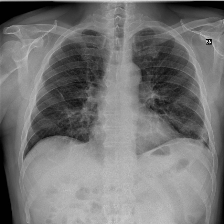

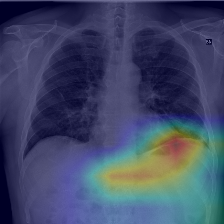

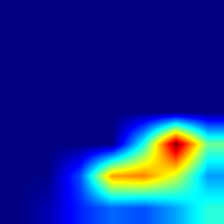

interarea: 3450
xA, yA, xB, yB: 86 121 200 150
boxAArea: 15251
boxBArea 14456
boxAArea + boxBArea - interArea:  26257
iou:  0.13139353315306396


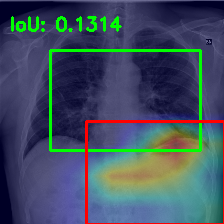

'/////////////////////////main-result/////////////////////////////'

In [13]:
# Test for example image


'''/////////////////////////main_grad use/////////////////////////////'''
temp_name = './assets/ex-covid.jpeg'
print("Current img:", temp_name)
img_m, new_im_2, cam3_resize = main_grad(temp_name)
'''/////////////////////////main_grad use/////////////////////////////'''


'''/////////////////////////show grad-cam area/////////////////////////////'''
img = cam3_resize

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
# cv2_imshow(binary)
contours, hierarchy = cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

cnt = contours[0]
x, y, w, h = cv2.boundingRect(cnt)
img_new = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 1)
# cv2_imshow(img_new)

'''/////////////////////////show grad-cam area/////////////////////////////'''

'''/////////////////////////main-result/////////////////////////////'''

image = new_im_2
# draw the ground-truth bounding box along with the predicted

# bounding box

# # left lung
# rect = plt.Rectangle((0.1,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# # right lung
# rect2 = plt.Rectangle((25,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# rect = plt.Rectangle((0.1,10), 45, 30, fill=False, edgecolor = 'red',linewidth=1)
detection1 = [50, 50, 200, 150] #15, 15, 200, 200
detection2 = [x, y, x + w, y + h]
start_point1 = [50, 50]  #10,10
end_point1 = [200, 150]  #200,150
color1 = (0, 255, 0)
start_point2 = [x, y]   # 137
end_point2 = [x+w, y+h]  # 188
color2 = (0, 0, 255)
thickness = 2

cv2.rectangle(image, start_point1, end_point1, color1, thickness)
cv2.rectangle(image, start_point2, end_point2, color2, thickness)



# compute the intersection over union and display it
iou = bb_intersection_over_union(detection1, detection2)
# iou = bb_intersection_over_union(detection.gt, detection.pred)
cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# show the output image
cv2_imshow(image)


'''/////////////////////////main-result/////////////////////////////'''


## loop for 10

In [19]:
# create folder to save
!mkdir ./output/

Current img: ryct.2020200034.fig2.jpeg


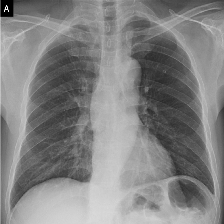

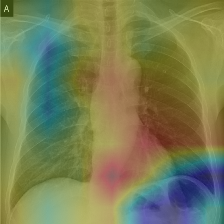

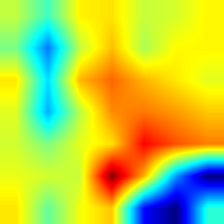

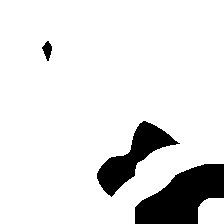

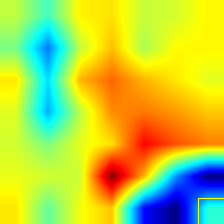

interarea: 0
xA, yA, xB, yB: 198 198 200 150
boxAArea: 15251
boxBArea 729
boxAArea + boxBArea - interArea:  15980
iou:  0.0


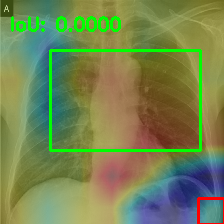

Current img: covid-19-pneumonia-7-PA.jpg


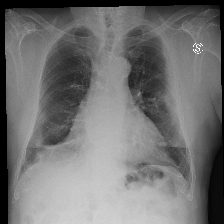

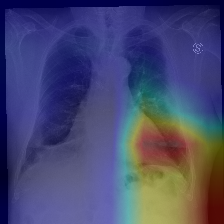

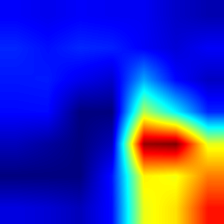

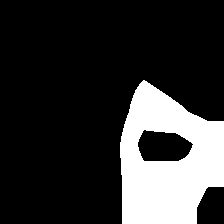

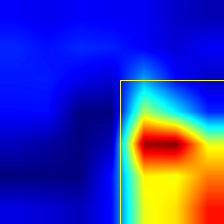

interarea: 5751
xA, yA, xB, yB: 120 80 200 150
boxAArea: 15251
boxBArea 15225
boxAArea + boxBArea - interArea:  24725
iou:  0.23259858442871587


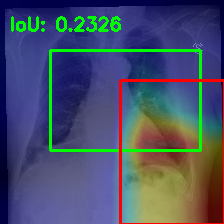

Current img: 44C8E3D6-20DA-42E9-B33B-96FA6D6DE12F.jpeg


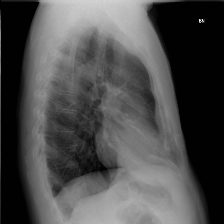

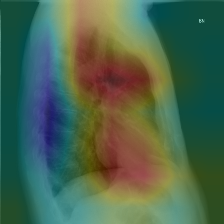

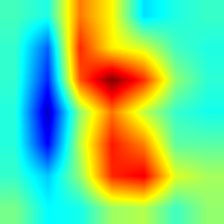

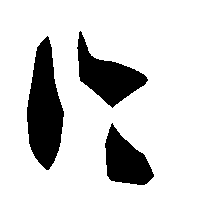

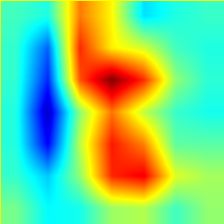

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


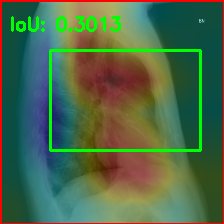

Current img: 2C10A413-AABE-4807-8CCE-6A2025594067.jpeg


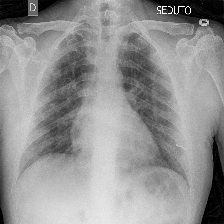

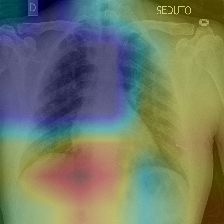

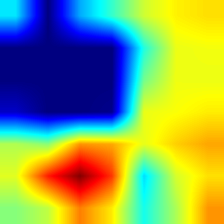

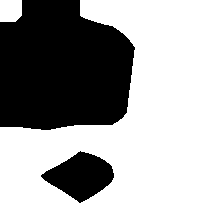

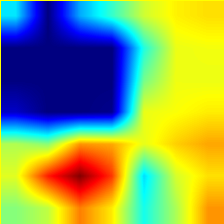

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


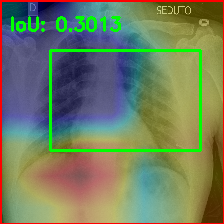

Current img: B59DD164-51D5-40DF-A926-6A42DD52EBE8.jpeg


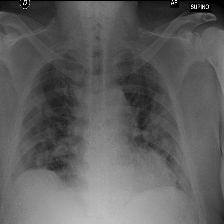

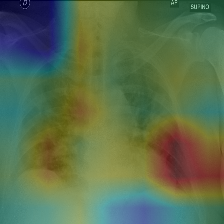

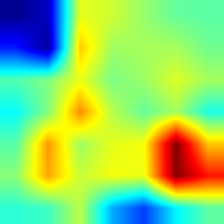

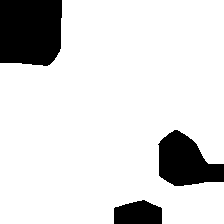

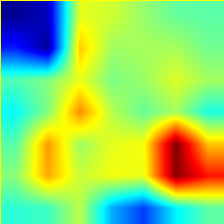

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


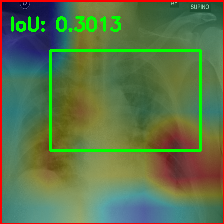

Current img: kjr-21-e24-g003-l-a.jpg


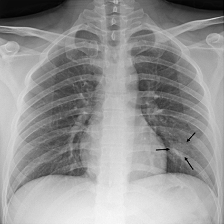

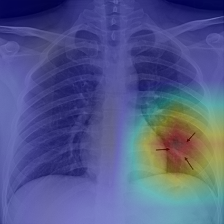

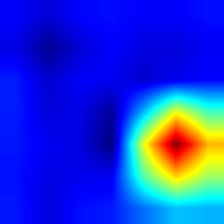

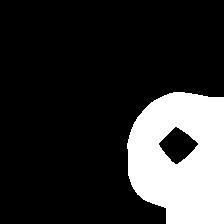

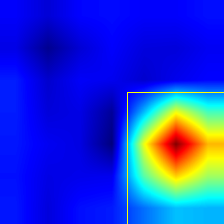

interarea: 4366
xA, yA, xB, yB: 127 92 200 150
boxAArea: 15251
boxBArea 13034
boxAArea + boxBArea - interArea:  23919
iou:  0.18253271457836867


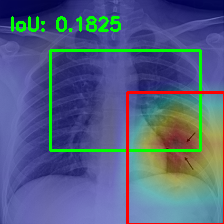

Current img: 58cb9263f16e94305c730685358e4e_jumbo.jpeg


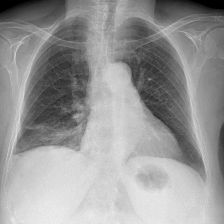

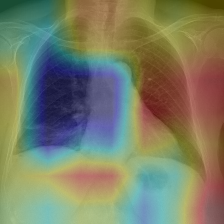

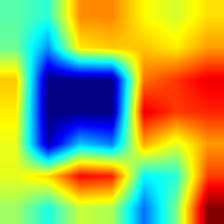

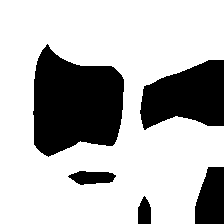

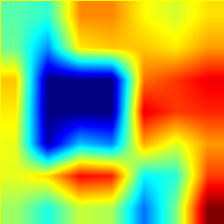

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


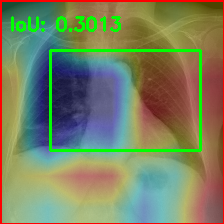

Current img: pneumocystis-jiroveci-pneumonia-2.png


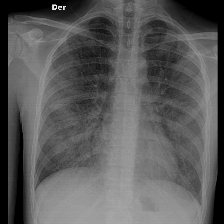

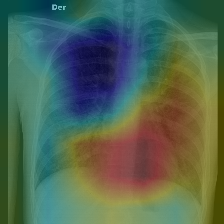

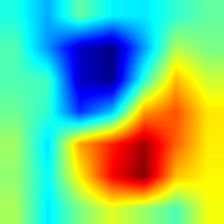

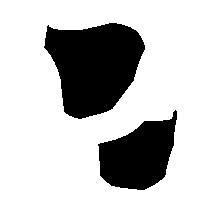

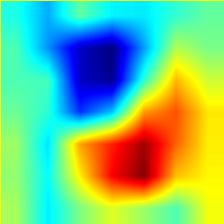

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


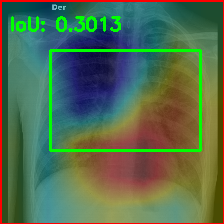

Current img: covid-19-caso-70-2-APS.jpg


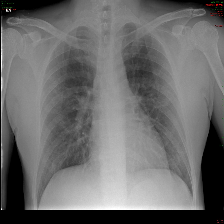

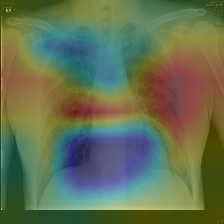

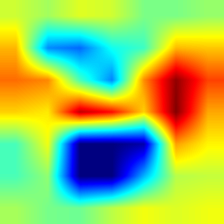

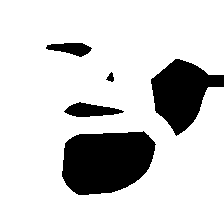

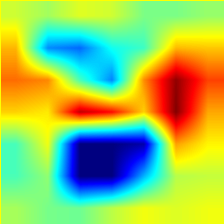

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


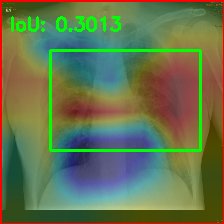

Current img: post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day7.jpg


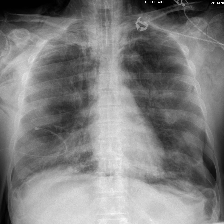

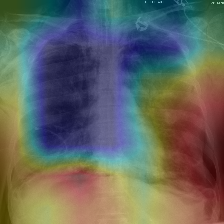

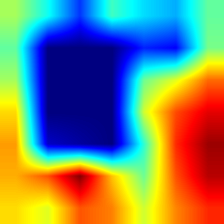

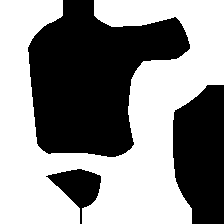

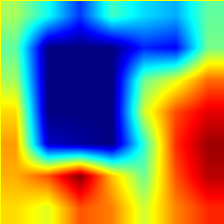

interarea: 15251
xA, yA, xB, yB: 50 50 200 150
boxAArea: 15251
boxBArea 50625
boxAArea + boxBArea - interArea:  50625
iou:  0.3012543209876543


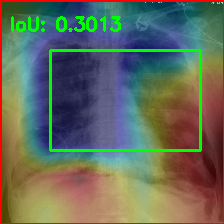

In [33]:
# change into loop

# for i in range(10):
#   num = img_num_set[i]
#   print("Num#:", num)
#   print(image_name_all[num])
#   temp_name = pd_reader['filename'][num]
#   print("Current img:", temp_name)
#   main_grad('./covid-chestxray-dataset-master/images/' + temp_name)
#   # main_grad('./covid-chestxray-dataset-master/images/' + image_name_all[num])
#   print(i, PCR_result_all[num])

iou_list = []
for i in range(10):
  '''/////////////////////////main_grad use/////////////////////////////'''
  num = img_num_set[i]
  temp_name = pd_reader['filename'][num]
  # temp_name = './assets/ex-covid.jpeg'
  print("Current img:", temp_name)
  # img_m = cv.imread(temp_name)
  # img_m = cv.resize(img_m, (224, 224))
  # cv2_imshow(img_m)
  img_m, new_im_2, cam3_resize = main_grad('./covid-chestxray-dataset-master/images/' + temp_name)
  # print(i, PCR_result_all[num])
  '''/////////////////////////main_grad use/////////////////////////////'''


  '''/////////////////////////show grad-cam area/////////////////////////////'''


  img = cam3_resize

  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
  cv2_imshow(binary)
  contours, hierarchy = cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  # print(contours)
  if contours is not None:
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    img_new = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 1)
    cv2_imshow(img_new)
  else:
    x, y, w, h = 0, 0, 0, 0
  '''/////////////////////////show grad-cam area/////////////////////////////'''

  '''/////////////////////////main-result/////////////////////////////'''

  image = new_im_2
  # draw the ground-truth bounding box along with the predicted

  # bounding box

  # # left lung
  # rect = plt.Rectangle((0.1,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
  # # right lung
  # rect2 = plt.Rectangle((25,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
  # rect = plt.Rectangle((0.1,10), 45, 30, fill=False, edgecolor = 'red',linewidth=1)
  detection1 = [50, 50, 200, 150] #15, 15, 200, 200
  detection2 = [x, y, x + w, y + h]
  start_point1 = [50, 50]  #10,10
  end_point1 = [200, 150]  #200,150
  color1 = (0, 255, 0)
  start_point2 = [x, y]   # 137
  end_point2 = [x+w, y+h]  # 188
  color2 = (0, 0, 255)
  thickness = 2

  cv2.rectangle(image, start_point1, end_point1, color1, thickness)
  cv2.rectangle(image, start_point2, end_point2, color2, thickness)



  # compute the intersection over union and display it
  iou = bb_intersection_over_union(detection1, detection2)
  # iou = bb_intersection_over_union(detection.gt, detection.pred)
  cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

  # show the output image
  cv2_imshow(image)
  iou_list.append(iou)
  cv2.imwrite("./output/IOU_"+temp_name, image)


  '''/////////////////////////main-result/////////////////////////////'''


In [34]:
# save
!cp -r ./output/ 'drive/MyDrive/covid/IOU_ex/'